<a href="https://colab.research.google.com/github/dominiquebuford/DL-individual/blob/main/DL_individualProject_NN_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from torch.optim import lr_scheduler

In [3]:
#create dataloader

df = pd.read_csv("../data/normalized_annotations_final.csv")
ignoreList = ['frisbee', 'lacrosse']
df = df[~df['Activity'].isin(ignoreList)]
df = df.drop(columns=df.columns[0]) #i need to update the files in my bucket so i don't have to do this
X = df.drop('Activity',axis=1).to_numpy()
y = df['Activity'].astype('category').cat.codes
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#resample the underrepresented classes
#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

y_resampled= np.array(y_resampled)
y_test = np.array(y_test)
trainset = TensorDataset(torch.from_numpy(X_resampled).float(),
                         torch.from_numpy(y_resampled).long())

testset = TensorDataset(torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test).long())

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)


In [4]:
categoryOrder = df['Activity'].astype('category').cat.categories

In [7]:
categoryOrder

Index(['basketball', 'bowling', 'boxing', 'football', 'golf', 'hacky sack',
       'rollerblading', 'rowing, stationary', 'skateboarding',
       'skiing, downhill', 'soccer', 'softball, general',
       'tennis, hitting balls, non-game play, moderate effort',
       'track and field'],
      dtype='object')

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'batch_size': [16, 32, 64],
    'hidden_layer_sizes': [(64,), (100,), (256,128)],
    'momentum': [0, 0.5, 0.1, 0.3]
}

def create_nn_model(learning_rate, batch_size, hidden_layer_sizes, momentum):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate,
        batch_size=batch_size,
        momentum = momentum
    )
    return model



nn_model = MLPClassifier()  # Initialize the base model
grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

In [ ]:
grid_search.best_score_

0.45588235294117646

In [16]:
df['Activity'].value_counts()

Activity
rowing, stationary                                       118
skateboarding                                            108
basketball                                                95
golf                                                      88
skiing, downhill                                          63
soccer                                                    59
softball, general                                         54
bowling                                                   38
hacky sack                                                34
boxing                                                    34
tennis, hitting balls, non-game play, moderate effort     30
football                                                  28
track and field                                           27
rollerblading                                             26
Name: count, dtype: int64

In [17]:
categoryOrder

Index(['basketball', 'bowling', 'boxing', 'football', 'golf', 'hacky sack',
       'rollerblading', 'rowing, stationary', 'skateboarding',
       'skiing, downhill', 'soccer', 'softball, general',
       'tennis, hitting balls, non-game play, moderate effort',
       'track and field'],
      dtype='object')

In [8]:
#define model, loss, optimizer
import torch.nn as nn

class PoseNet(nn.Module):
  def __init__(self, input_size, hidden_size_1, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size_1)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size_1, num_classes)
    self.dropout = nn.Dropout(p=0.3)
    self.bn1 = nn.BatchNorm1d(100)
    self.bn2 = nn.BatchNorm1d(num_classes)
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer2(x)
    return x

model = PoseNet(32, 100,14)

#class_frequencies = np.array([170, 50, 49, 87, 138, 46, 34, 89, 150, 184, 202, 137, 173, 37, 41])

# Calculate the imbalance ratio for each class
#total_samples = sum(class_frequencies)
#class_ratios = class_frequencies / total_samples
#imbalance_ratios = 1 / class_ratios

# Use the imbalance ratios as class weights
#class_weights = list(imbalance_ratios)
#class_weights = torch.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=0.015, weight_decay=weight_decay)



Epoch 1/50, Loss: 2.0745537281036377
Epoch 2/50, Loss: 2.0786232948303223
Epoch 3/50, Loss: 1.9333171844482422
Epoch 4/50, Loss: 1.9724115133285522
Epoch 5/50, Loss: 1.5658234357833862
Epoch 6/50, Loss: 1.3158185482025146
Epoch 7/50, Loss: 1.754971981048584
Epoch 8/50, Loss: 1.1934014558792114
Epoch 9/50, Loss: 1.15572988986969
Epoch 10/50, Loss: 0.8694869875907898
Epoch 11/50, Loss: 0.6580811142921448
Epoch 12/50, Loss: 0.7360284328460693
Epoch 13/50, Loss: 1.0611884593963623
Epoch 14/50, Loss: 1.205647349357605
Epoch 15/50, Loss: 0.9637559056282043
Epoch 16/50, Loss: 0.8157651424407959
Epoch 17/50, Loss: 1.2804763317108154
Epoch 18/50, Loss: 0.6815747618675232
Epoch 19/50, Loss: 0.7583718299865723
Epoch 20/50, Loss: 1.0454450845718384
Epoch 21/50, Loss: 1.17239511013031
Epoch 22/50, Loss: 0.7212714552879333
Epoch 23/50, Loss: 0.8203379511833191
Epoch 24/50, Loss: 0.8940615653991699
Epoch 25/50, Loss: 1.040172815322876
Epoch 26/50, Loss: 0.5581437349319458
Epoch 27/50, Loss: 0.8849893

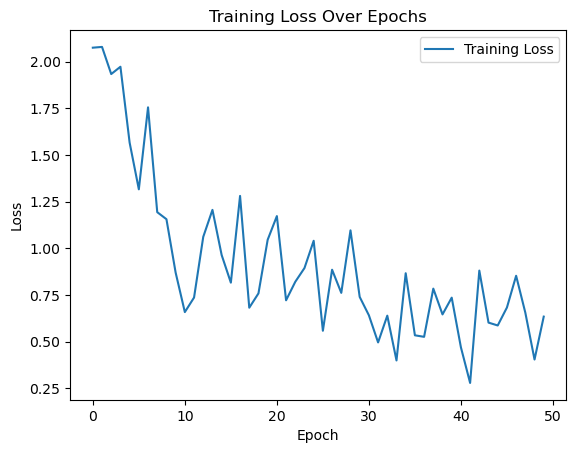

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

#train the model
num_epochs = 50
losses = []
model = model.to(device) # Send model to GPU if available
model.train()
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
    losses.append(loss.item())
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

plt.plot(losses, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Show a legend
plt.legend()

# Show the plot
plt.show()

In [13]:
with torch.no_grad():

    # Set the model to evaluation mode
    model.eval()
    input_array = np.array([-0.0614,  0.5283, -0.0536,  0.2932, -0.0088, -0.0073,  0.0088,
           0.0073, -0.0244,  0.3049, -0.0263,  0.6024,  0.0039,  0.0083,
          -0.0906, -0.2727, -0.1296, -0.2658, -0.1832, -0.3790, -0.1364,
           0.1293, -0.1218, -0.0522, -0.1539, -0.2249, -0.0984, -0.2795,
          -0.1140, -0.0639, -0.1383,  0.1273], dtype = np.float32)
    
    
    input_tensor = torch.from_numpy(input_array).to(device)
    input_tensor = input_tensor.unsqueeze(0)
    output = model.forward(input_tensor)
    probabilities = F.softmax(output, dim=-1)
    predicted_class = np.argmax(probabilities.cpu().numpy(),axis=-1)
    

In [15]:
probabilities

tensor([[1.3542e-01, 9.2209e-10, 6.5507e-12, 5.7756e-16, 2.1519e-10, 7.2519e-14,
         2.1882e-10, 9.4331e-18, 8.6458e-01, 5.0684e-15, 1.0231e-07, 1.2155e-11,
         2.1220e-13, 1.2608e-07]])

In [ ]:
torch.save(model.state_dict(), 'model1_weight_decay_1hidden100_learningrate0.01.pth')

In [18]:
with torch.no_grad():

    # Set the model to evaluation mode
    model.eval()

    # Set up lists to store true and predicted values
    y_true = []
    test_preds = []

    # Calculate the predictions on the test set and add to list
    for data in testloader:
      inputs, labels = data[0].to(device), data[1].to(device)
      # Feed inputs through model to get raw scores
      logits = model.forward(inputs)
      # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
      probs = F.softmax(logits,dim=1)
      # Get discrete predictions using argmax
      probsList = probs.tolist()
      topThreeCategories = []
      for batch_input in probsList:
        top_indices = sorted(range(len(batch_input)), key=lambda i: batch_input[i], reverse=True)[:4]
        categoryList = [categoryOrder[i] for i in top_indices]
        topThreeCategories.append(categoryList)
      labelsList = labels.tolist()
      labelsCategories = [categoryOrder[i] for i in labelsList]
      preds = np.argmax(probs.cpu().numpy(),axis=1)
      test_preds.extend(preds)
      labels = [tensor.item() for tensor in labels]
      y_true.extend(labels)
      print("predList", topThreeCategories)
      print("trueList", labelsCategories)
      count = 0
      for i in range(len(topThreeCategories)):
        if labelsCategories[i] in(topThreeCategories[i]):
          count+=1
      print(count/len(labelsCategories))
      # Calculate the accuracy

    count=0
    for i in range(len(test_preds)):
      if test_preds[i] == y_true[i]:
        count+=1
    print(count/len(y_true))




predList [['football', 'soccer', 'softball, general', 'track and field'], ['skateboarding', 'basketball', 'rowing, stationary', 'rollerblading'], ['skiing, downhill', 'skateboarding', 'basketball', 'soccer'], ['golf', 'softball, general', 'basketball', 'tennis, hitting balls, non-game play, moderate effort'], ['basketball', 'skateboarding', 'skiing, downhill', 'rollerblading'], ['softball, general', 'track and field', 'golf', 'hacky sack'], ['golf', 'skateboarding', 'basketball', 'tennis, hitting balls, non-game play, moderate effort'], ['boxing', 'track and field', 'softball, general', 'golf'], ['soccer', 'tennis, hitting balls, non-game play, moderate effort', 'football', 'basketball'], ['soccer', 'track and field', 'softball, general', 'skateboarding'], ['skateboarding', 'basketball', 'rollerblading', 'skiing, downhill'], ['skiing, downhill', 'basketball', 'skateboarding', 'soccer'], ['golf', 'softball, general', 'basketball', 'skateboarding'], ['basketball', 'skateboarding', 'softb

In [35]:
#single predictions-exaggerated poses
df_check = pd.read_csv('normalized_annotations.csv')
df_final = df_check[df_check['Unnamed: 0']==6648]
print(df_final.columns.tolist())
df_final_noactivity = df_final.drop(columns= ['Activity', 'Unnamed: 0'])
row_to_use = df_final_noactivity.iloc[0]
# Step 2: Extract the input features and convert to a PyTorch tensor
your_input_data = torch.tensor(row_to_use.values, dtype=torch.float32)

# Step 3: Reshape the tensor if needed (for example, if it's a 1D tensor)
your_input_data = your_input_data.view(1, -1)  # Reshape to a row vector

# Step 4: Call the model's forward method
logits = model.forward(your_input_data)

# Step 5: Optionally apply softmax for probabilities
probabilities = F.softmax(logits, dim=1)

print(probabilities)
print(categoryOrder)

FileNotFoundError: [Errno 2] No such file or directory: 'normalized_annotations.csv'

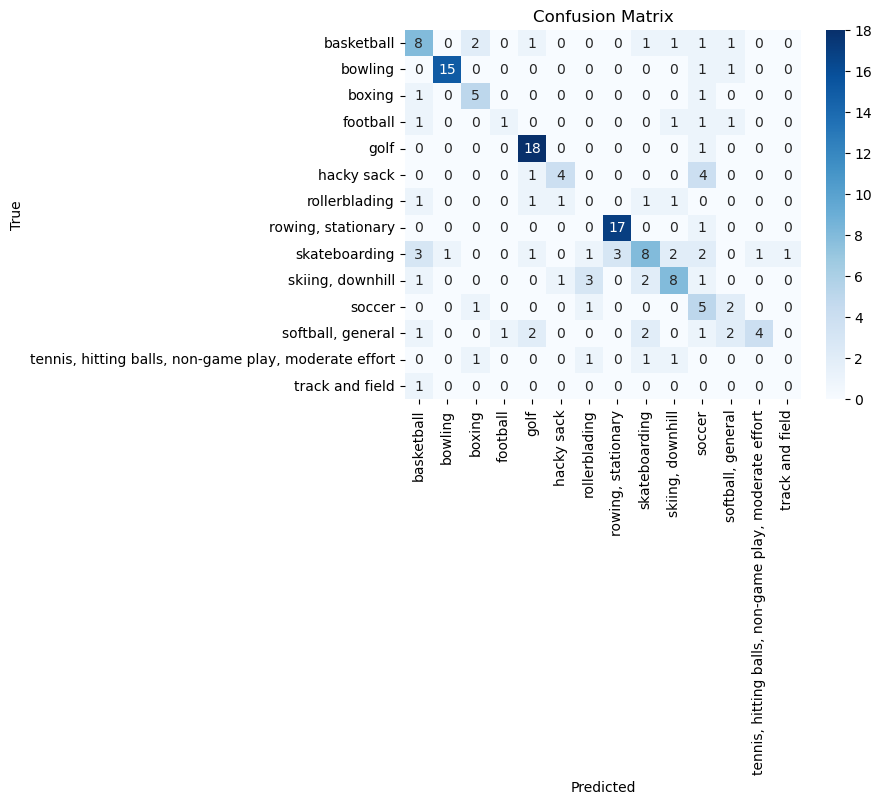

In [19]:


# Assuming you have your predicted and true labels

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, test_preds)

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categoryOrder, yticklabels=categoryOrder)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true,test_preds, average = 'macro')

0.3764194778598237

In [ ]:
df['Activity'].value_counts()

skiing, downhill      202
skateboarding         184
softball, general     173
basketball            170
rowing, stationary    150
golf                  138
soccer                137
rollerblading          89
frisbee                87
football               56
bowling                50
boxing                 49
hacky sack             46
Name: Activity, dtype: int64